In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

if torch.cuda.is_available():
    GPU_SCORE = torch.cuda.get_device_capability()
    if GPU_SCORE >= (8, 0):
        torch.backends.cuda.matmul.allow_tf32 = True

Classe: esox lucius


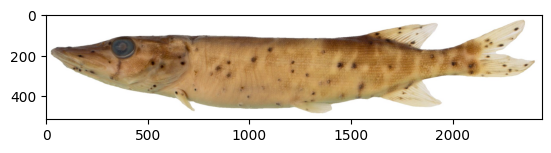

In [47]:
from PIL import Image
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set the the fish_vista_repo_dir to the path of your cloned fish-vista HF repository
fish_vista_repo_dir = "dataset/fish-vista/"

# Read classification test and train csv files
train_path = os.path.join(fish_vista_repo_dir, "classification_train.csv")
train_df = pd.read_csv(train_path)

test_path = os.path.join(fish_vista_repo_dir, "classification_test.csv")
test_df = pd.read_csv(test_path)

# Get image at index 'idx'
idx = 4952
img_class = train_df.iloc[idx].standardized_species
if (train_df.iloc[idx].license == "CC BY-NC-ND"): img_filename = "Images/" + train_df.iloc[idx].filename
else: img_filename = train_df.iloc[idx].file_name

img_test = Image.open(os.path.join(fish_vista_repo_dir, img_filename))
plt.imshow(img_test)
print(f"Classe: {img_class}")

In [57]:
import os
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms

class FishDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, target_transform=None):
        self.dataframe = dataframe
        self.img_labels = dataframe["standardized_species"].unique()
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataframe["filename"])

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx].standardized_species
        if (train_df.iloc[idx].license == "CC BY-NC-ND"): img_filename = "Images/" + self.dataframe.iloc[idx].filename
        else: img_filename = self.dataframe.iloc[idx].file_name
        image = Image.open(self.root_dir + img_filename)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [63]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize(size=(64, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [ ]:
train_dataset = FishDataset(train_df,fish_vista_repo_dir,data_transform)
test_dataset = FishDataset(test_df,fish_vista_repo_dir,data_transform)

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=1, 
                              num_workers=os.cpu_count(), 
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=1, 
                             num_workers=os.cpu_count(), 
                             shuffle=False)